In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import pickle
from bs4 import BeautifulSoup
import os
import os.path
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()
import textblob
from textblob import Word
import re

## Read the data from the page using the URL

In [2]:
def extract_transcript_using_url(url):
    response = requests.get(url)
    if response.status_code == requests.codes.ok:        
        page = response.text
        soup = BeautifulSoup(page, 'lxml')
    
        text = [p.text for p in soup.find(class_="inline canwrap").find_all('p')]
        rating = [p.text for p in soup.find(class_="ratingValue").find_all('span', {'itemprop': 'ratingValue'})]
        totalReviews = [p.text for p in soup.find(class_="imdbRating").find_all('span', {'itemprop': 'ratingCount'})]
        duration = [p.text for p in soup.find(class_="subtext").find_all('time')]
        releaseDate = [p.text for p in soup.find(class_="subtext").find_all('a', {'title': 'See more release dates'})]
        director = [p.text for p in soup.find(class_="credit_summary_item").find_all('a')]

        return text[0], rating[0], totalReviews[0], duration[0], releaseDate[0], director[0]
    
    return None

In [3]:
returnValues = extract_transcript_using_url('https://www.imdb.com/title/tt0169102/?ref_=fn_al_tt_1')
#text,
#rating, 
#totalReviews, 
#duration, 
#releaseDate 
#director

## Define the URL and movies name

In [4]:
urls = ['https://www.imdb.com/title/tt0169102/?ref_=fn_al_tt_1',
       'https://www.imdb.com/title/tt1187043/?ref_=tt_sims_tti',
       'https://www.imdb.com/title/tt5074352/?ref_=tt_sims_tti',
       'https://www.imdb.com/title/tt2338151/?ref_=tt_sims_tti',
       'https://www.imdb.com/title/tt0405508/?ref_=tt_sims_tti',
       'https://www.imdb.com/title/tt1954470/?ref_=tt_sims_tti',
       'https://www.imdb.com/title/tt8108198/?ref_=tt_sims_tti',
       'https://www.imdb.com/title/tt7725596/?ref_=tt_sims_tti',
       'https://www.imdb.com/title/tt8108202/?ref_=tt_sims_tti',
       'https://www.imdb.com/title/tt7098658/?ref_=tt_sims_tti']

moviesName = ['Lagaan',
              '3 Idiots','Dangal','pk','Rang De Basanti',
              'Gangs of Wasseypur','Andhadhun','Badhaai Ho','Stree','Raazi']

### Extract the contents and save in the file

In [5]:
contents = [extract_transcript_using_url(url) for url in urls]

## make directory..
name = 'Movies'
isdir = os.path.isdir(name)
if isdir == False:
    os.mkdir(name)

## dump the data
for i, m in enumerate(moviesName):
    with open('Movies/' + m + ".txt", 'wb') as file:
        pickle.dump(contents[i], file)
        

## load the data
data = {}

for i, m in enumerate(moviesName):
    with open('Movies/' + m + ".txt", 'rb') as file:
        data[m] = pickle.load(file)

In [6]:
data.keys()

dict_keys(['Lagaan', '3 Idiots', 'Dangal', 'pk', 'Rang De Basanti', 'Gangs of Wasseypur', 'Andhadhun', 'Badhaai Ho', 'Stree', 'Raazi'])

In [7]:
data['Dangal'][1]

'8.4'

In [8]:
def get_duration_min(duration):
    duration = duration.strip()
    str = duration.split(" ")
    
    hours = int(re.sub('h', '', str[0]))
    minuts = int(re.sub('min', '', str[1]))
    total_min = hours*60 + minuts
    
    return total_min

In [9]:
data_list = []
for key, item in data.items():
    d = []
    d.append(key)
    text = re.sub("\n", "", item[0])
    d.append(text)
    
    rating = re.sub("\n", "", item[1])
    d.append(rating)
    
    reviews = re.sub("\n", "", item[2])
    d.append(reviews)
    
    duration = re.sub("\n", "", item[3])
    d.append(get_duration_min(duration))
    releaseDate = re.sub("\n", "", item[4])
    d.append(releaseDate)
    
    data_list.append(d)

##### 

In [10]:
df = pd.DataFrame(data_list)
df.columns = ['movie_name', 'transcript', 'rating', 'total_reviews', 'duration', 'release_date']

In [11]:
df_filtered = df[['movie_name','transcript']]

In [12]:
df_filtered.set_index(["movie_name"], inplace = True, append = False, drop = True) 
   
df_filtered.index.name = None
#df_transpose = df_filtered.transpose()

#df_filtered.transcript.loc['Lagaan']

### Data cleaning

In [13]:
def text_cleaning_1(text):
    text = text.lower()
    text = re.sub(r'\b\d+(?:\.\d+)?\s+','',text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub("\n", "", text)
    
    return text

rnd_1 = lambda x: text_cleaning_1(x)

data_clean = pd.DataFrame(df_filtered.transcript.apply(rnd_1))

data_clean['name'] = moviesName

data_clean.to_pickle('corpus.pkl')

### Using bag of words

In [14]:
## stemming step..
data_clean['transcript'] = data_clean['transcript'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))

## lemmatization..
data_clean['transcript'] = data_clean['transcript'].apply(lambda x: " ".join([lemma.lemmatize(word) for word in x.split()]))


cv = CountVectorizer(ngram_range=(1,1), stop_words='english')
data_cv = cv.fit_transform(data_clean.transcript)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

data_dtm.index = data_clean.index

#data_dtm

In [15]:
data = data_dtm.transpose()

## find top 10 words by each movie
top_dict = {}

for c in data.columns:
    top = data[c].sort_values(ascending=False).head(10)
    top_dict[c] = list(zip(top.index, top.values))

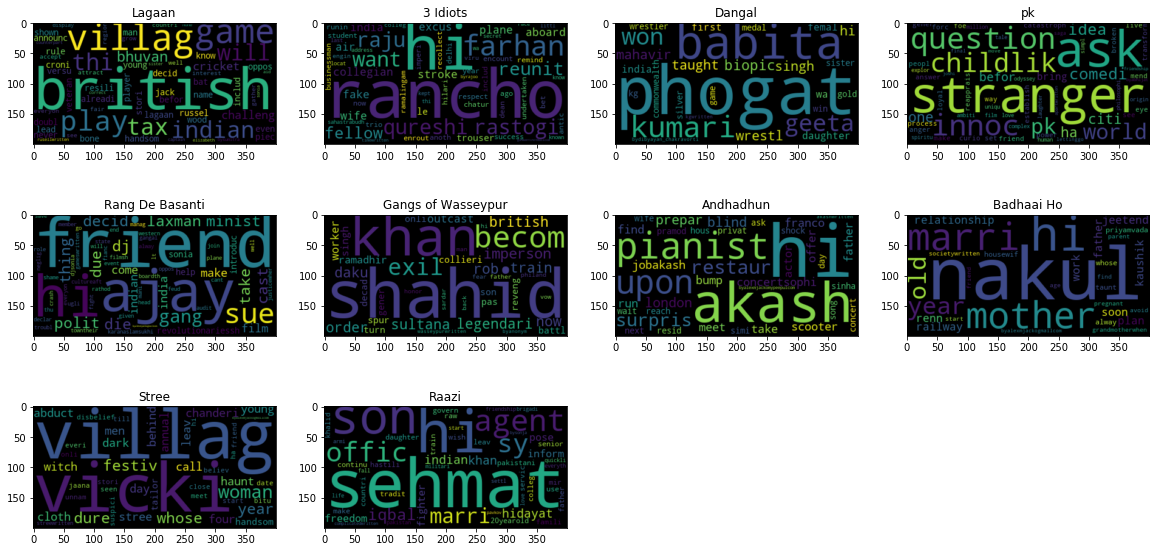

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(random_state=21, max_font_size=119)
plt.rcParams['figure.figsize'] = [20,10]
for index, movie in enumerate(data.columns):
    wc = wordcloud.generate(data_clean.transcript[movie])
    
    plt.subplot(3,4, index+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(moviesName[index])
    
plt.show()

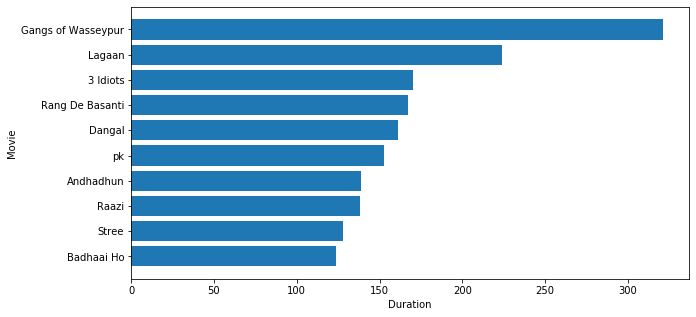

In [28]:
df = df.sort_values(by=['duration'])
plt.rcParams['figure.figsize'] = [10,5]
plt.barh(df['movie_name'], df['duration'])
plt.xlabel('Duration')
plt.ylabel('Movie')
plt.show()

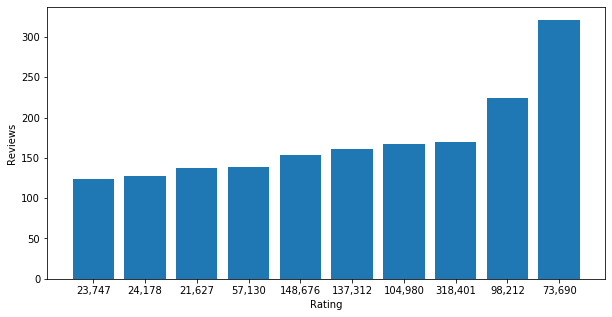

In [37]:
#df = df.sort_values(by=['duration'])
plt.rcParams['figure.figsize'] = [10,5]
plt.bar(df['total_reviews'], df['duration'])
plt.xlabel('Rating')
plt.ylabel('Reviews')
plt.show()

In [31]:
df

,movie_name,transcript,rating,total_reviews,duration,release_date
8,Stree,Chanderi village is haunted for years by a...,7.6,"24,178",128,31 August 2018 (India)
9,Raazi,Hidayat Khan is the son of an Indian freed...,7.8,"21,627",138,11 May 2018 (India)
7,Badhaai Ho,Nakul a 25 year old in relationship with R...,8.0,"23,747",124,18 October 2018 (India)
3,pk,P. K. is a comedy of ideas about a strange...,8.1,"148,676",153,19 December 2014 (India)
0,Lagaan,This is the story about the resilience sho...,8.1,"98,212",224,15 June 2001 (India)
4,Rang De Basanti,Sue comes to India to make a film on India...,8.2,"104,980",167,26 January 2006 (India)
5,Gangs of Wasseypur,Shahid Khan is exiled after impersonating ...,8.2,"73,690",321,22 June 2012 (India)
6,Andhadhun,Akash a blind pianist is preparing for a L...,8.3,"57,130",139,5 October 2018 (India)
2,Dangal,"Biopic of Mahavir Singh Phogat, who taught...",8.4,"137,312",161,23 December 2016 (India)
1,3 Idiots,Farhan Qureshi and Raju Rastogi want to re...,8.4,"318,401",170,25 December 2009 (India)
